MINEの公式実装論文そのまま．
models/mine.pyで実装したMINEのクラスに問題ないかを確認した（prc_test.ipynb）.
(そのため，シード値を共通にしている．)

https://github.com/sungyubkim/MINE-Mutual-Information-Neural-Estimation-/blob/master/MINE.ipynb


# Basic experiment

# Make toy data

## Type 1. Independent Gaussian

$$
(x_1, x_2) \sim \mathcal{N}(0,I)
$$

## Type 2. Correlated Gaussian

$$
(y_1, y_2) \sim \mathcal{N}(0,\begin{bmatrix}1&\rho\\ \rho&1\end{bmatrix})
$$

In [1]:
import numpy as np
import torch
import random

# シード値を指定する
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_value)

In [2]:
x = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,0],[0,1]],
                                 size = 300)
x = torch.from_numpy(x).float()

In [3]:
y = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,0.8],[0.8,1]],
                                 size = 300)
y = torch.from_numpy(y).float()


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

<AxesSubplot: >

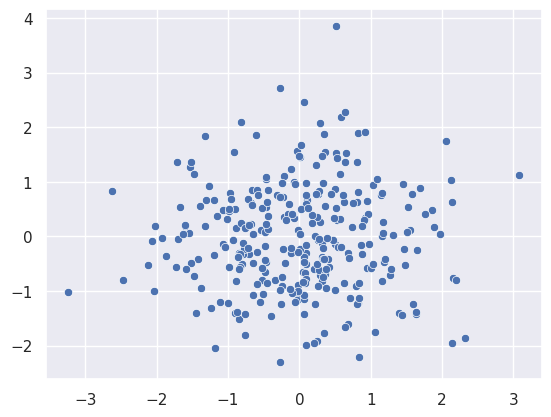

In [5]:
# plt indep Gaussian
sns.scatterplot(x=x[:,0],y=x[:,1])

<AxesSubplot: >

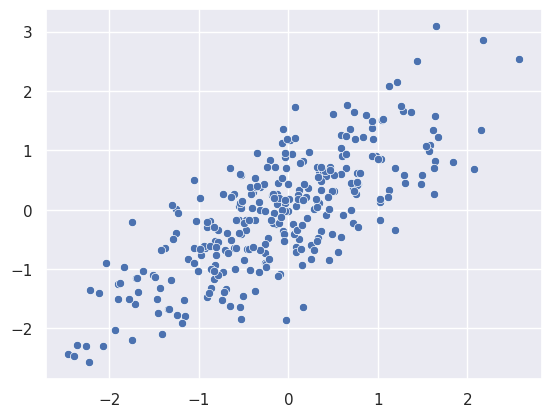

In [6]:
# plt cor Gaussian
sns.scatterplot(x=y[:,0],y=y[:,1])

# Define MINE

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd


In [8]:
class Mine(nn.Module):
    def __init__(self, input_size=2, hidden_size=100):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ELU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ELU(),
            nn.Linear(hidden_size, 1)
        )
        for module in self.model.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, std=0.02)
                nn.init.constant_(module.bias, 0)
        
    def forward(self, input):
        output = self.model(input)
        return output

In [9]:
# # OK
# def mutual_information(joint, marginal, mine_net):
#     t = mine_net(joint)
#     et = torch.exp(mine_net(marginal))
#     mi_lb = torch.mean(t) - torch.log(torch.mean(et))
#     return mi_lb, t, et

# def get_loss(data, mine_net, ma_et, ma_rate=0.01):
#     # batch is a tuple of (joint, marginal)
#     joint = sample_batch(data, batch_size=100).float().cuda()
#     marginal = sample_batch(data, batch_size=100, sample_mode='marginal').float().cuda()
#     mi_lb , t, et = mutual_information(joint, marginal, mine_net)
#     ma_et = (1 - ma_rate) * ma_et + ma_rate * torch.mean(et)
    
#     # unbiasing use moving average
#     loss = -(torch.mean(t) - (1/ma_et.mean()).detach()*torch.mean(et))
#     # use biased estimator
# #     loss = - mi_lb
    
#     return loss, mi_lb, ma_et

# def ma(a, window_size=100):
#     # return [torch.mean(a[i:i + window_size]) for i in range(0, len(a) - window_size)]
#     return [np.mean(a[i:i+window_size]) for i in range(0,len(a)-window_size)]

# # OK
def sample_batch(data, batch_size=100, sample_mode='joint'):
    if sample_mode == 'joint':
        index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = data[index]
    else:
        joint_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        marginal_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = torch.cat([data[joint_index][:,0].reshape(-1,1),
                            data[marginal_index][:,1].reshape(-1,1)],
                            dim=1)
    return batch

# def train(data, mine_net, mine_net_optim, batch_size=100, iter_num=int(5e+3), log_freq=int(1e+3)):
#     result = []
#     ma_et = 1.
#     for i in range(iter_num):
#         mine_net_optim.zero_grad()
#         loss, mi_lb, ma_et = get_loss(data, mine_net, ma_et)
#         loss.backward()
#         mine_net_optim.step()

#         result.append(mi_lb.detach().cpu().numpy())
#         if (i + 1) % (log_freq) == 0:
#             print(result[-1])
#     return result

In [10]:
class MineTrainer():
    def __init__(self, mine_net):
        super().__init__()
        self.mine_net = mine_net
        # self.mine_net_optim = optimizer
        # self.mine_net_optim = optim.Adam(self.mine_net.parameters(), lr=1e-3)
        self.ma_rate=0.01
        self.batch_size = 100
        self.ma_et = 1.
    # OK
    def _mutual_information(self, joint, marginal):
        t = self.mine_net(joint)
        et = torch.exp(self.mine_net(marginal))
        mi_lb = torch.mean(t) - torch.log(torch.mean(et))
        return mi_lb, t, et

    def _ma(self, a, window_size=100):
        # return [torch.mean(a[i:i + window_size]) for i in range(0, len(a) - window_size)]
        return [np.mean(a[i:i+window_size]) for i in range(0,len(a)-window_size)]
        
    def _get_loss(self, data):
        # batch is a tuple of (joint, marginal)
        joint = self._sample_batch(data, 'joint').float().cuda()
        marginal = self._sample_batch(data, 'marginal').float().cuda()
        mi_lb, t, et = self._mutual_information(joint, marginal)
        self.ma_et = (1 - self.ma_rate) * self.ma_et + self.ma_rate * torch.mean(et)
        # unbiasing use moving average
        #####################  TODO: detach必要?  #####################
        loss = -(torch.mean(t) - (1 / self.ma_et.mean()).detach() * torch.mean(et))
        # use biased estimator
    #     loss = - mi_lb
        return loss, mi_lb

    # OK
    def _sample_batch(self, data, sample_mode='joint'):
        if sample_mode == 'joint':
            index = np.random.choice(range(data.shape[0]), size=self.batch_size, replace=False)
            batch = data[index]
        else:
            joint_index = np.random.choice(range(data.shape[0]), size=self.batch_size, replace=False)
            marginal_index = np.random.choice(range(data.shape[0]), size=self.batch_size, replace=False)
            batch = torch.cat([data[joint_index][:,0].reshape(-1,1),
                                data[marginal_index][:,1].reshape(-1,1)],
                                dim=1)
        return batch

    def _train(self, data, iter_num=int(5e+3), log_freq=int(1e+3)):
        result = []
        for i in range(iter_num):
            self.mine_net_optim.zero_grad()
            loss, mi_lb = self._get_loss(data)
            loss.backward()
            self.mine_net_optim.step()

            result.append(mi_lb.detach().cpu().numpy())
            if (i + 1) % (log_freq) == 0:
                print(result[-1])
        return result

In [11]:
joint_data = sample_batch(y,batch_size=100,sample_mode='joint')
marginal_data = sample_batch(y,batch_size=100,sample_mode='marginal')
# sns.scatterplot(x=joint_data[:,0],y=joint_data[:,1],color='red')
# sns.scatterplot(x=marginal_data[:,0],y=marginal_data[:,1])

In [12]:
# mine_net_indep = Mine().cuda()
# mine_net_optim_indep = optim.Adam(mine_net_indep.parameters(), lr=1e-3)
# result_indep = train(x, mine_net_indep, mine_net_optim_indep)
mine_net_indep = Mine().cuda()
mine_trainer = MineTrainer(mine_net_indep)
mine_trainer.mine_net_optim = optim.Adam(mine_net_indep.parameters(), lr=1e-3)
result_indep = mine_trainer._train(x)

2.3866698e-05
-1.991808e-05
-3.5522498e-06
2.244371e-06
7.737006e-05


In [13]:
result_indep_ma = ma(result_indep)
print(result_indep_ma[-1])
# plt.plot(range(len(result_indep_ma)),result_indep_ma)

6.8847015e-07


In [14]:
mine_net_cor = Mine().cuda()
mine_net_optim_cor = optim.Adam(mine_net_cor.parameters(), lr=1e-3)
result_cor = train(y,mine_net_cor,mine_net_optim_cor)

0.5070225
0.37440306
0.7741264
0.41337585
0.4143136


0.43775833


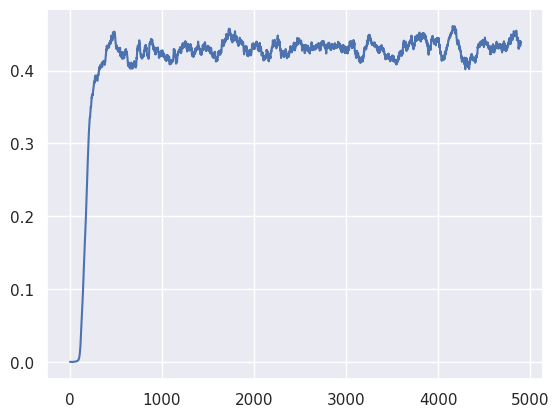

In [15]:
result_cor_ma = ma(result_cor)
print(result_cor_ma[-1])
plt.plot(range(len(result_cor_ma)),result_cor_ma)

# Test with various correlations

In [16]:
correlations = np.linspace(-0.9,0.9,19)
print(correlations)

[-0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4
  0.5  0.6  0.7  0.8  0.9]


In [17]:
final_result = []
for rho in correlations:
    rho_data = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,rho],[rho,1]],
                                 size = 300)
    mine_net = Mine().cuda()
    mine_net_optim = optim.Adam(mine_net.parameters(), lr=1e-3)
    result = train(rho_data,mine_net,mine_net_optim)
    result_ma = ma(result)
    final_result.append(result_ma[-1])
    print(str(rho) + ' : ' + str(final_result[-1]))
    plt.plot(range(len(result_ma)),result_ma)

AttributeError: 'numpy.ndarray' object has no attribute 'float'

In [ ]:
plt.plot(correlations, final_result)

# Equitability experiment

Check more information at [original equitability paper](http://www.pnas.org/content/pnas/111/9/3354.full.pdf).

# Make toy data

In [ ]:
x = np.random.uniform(low=-1.,high=1.,size=3000)
f1 = x
f2 = 2*x
f3 = np.sin(x)
f4 = x**3
eps = np.random.normal(size=3000)

In [ ]:
sns.scatterplot(x, f1,color='red')
sns.scatterplot(x, f2,color='blue')
sns.scatterplot(x, f3,color='green')
sns.scatterplot(x, f4,color='purple')

In [ ]:
sigmas = np.linspace(0.0,0.9,10)
fs = [f1, f2, f3, f4]
print(sigmas)

In [ ]:
final_result = []
for sigma in sigmas:
    for fi, f in enumerate(fs):
        data = np.concatenate([x.reshape(-1,1), (f + sigma * eps).reshape(-1,1)], axis=1)
        mine_net = Mine().cuda()
        mine_net_optim = optim.Adam(mine_net.parameters(), lr=1e-3)
        result = train(data,mine_net,mine_net_optim,iter_num=int(5e+3))
        result_ma = ma(result)
        final_result.append(result_ma[-1])
        print(str(sigma) + ',' + str(fi) +' : ' + str(final_result[-1]))
        plt.plot(range(len(result_ma)),result_ma)

In [ ]:
re_final_result = np.transpose(np.array([final_result[4*i: 4*i+4]  for i in range(10)]))
print(re_final_result)

In [ ]:
sns.heatmap(re_final_result,cmap="YlGnBu",linewidths=.5)